<a href="https://colab.research.google.com/github/kengmingcheng/Concrete_Strength_Prediction/blob/master/ResNet/(new_data)ResNet18_for_us_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 3.8MB 43.0MB/s 
     |████████████████████████████████| 512kB 55.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c3756523c169ecda6834fe858a3e767b04d89099420e5626848772fca54fab65
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc1 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0rc1 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.1.1
    Uninst

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor

# tensorflow
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, Activation, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

print(tf.__version__)

1.15.0


In [ ]:
# import data
from google.colab import files, drive
drive.mount("/content/gdrive")
# files.upload()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download_link = "https://drive.google.com/open?id=1niFDtDbD-NtI0fINwxGidgAoVgRI5r1g"
fluff, id_down = download_link.split('=')
print("File ID: {}".format(id_down))

file = drive.CreateFile({'id':id_down}) 
file.GetContentFile('clean_data_28days.csv')

US_Data_Link = "https://drive.google.com/open?id=1kx_05DRuYGO8tqDLrwXTpgCVk-221MEd"
url2, id_usdata = US_Data_Link.split('=')
print("US data ID: {}".format(id_usdata))
file = drive.CreateFile({'id':id_usdata})
file.GetContentFile('US_concrete_clean.csv')

upload_link = "https://drive.google.com/open?id=1OPkyRvIKKjor9RspmfJ2eP9c02rXNzKV"
url, id_up = upload_link.split('=')
print("Upload folder ID: {}".format(id_up))

File ID: 1niFDtDbD-NtI0fINwxGidgAoVgRI5r1g
US data ID: 1kx_05DRuYGO8tqDLrwXTpgCVk-221MEd
Upload folder ID: 1OPkyRvIKKjor9RspmfJ2eP9c02rXNzKV


In [ ]:
# df_data = pd.read_csv('clean_data_28days.csv')
df_data = pd.read_csv('US_concrete_clean.csv', index_col = 0)
df_data.head()

,Fraction_cement,Fraction_fine agg,Fraction_fly ash,Fraction_Slag,Air entraining agent,Water reducing admixture,Retarder,Accelerator,28D Strength
W/CM,,,,,,,,,
0.45,13.715645,38.927061,2.431290,0.000000,0.0,3.927987,0.0,0.0,6220
0.35,12.274549,36.022044,0.000000,5.260521,0.0,4.000000,3.0,0.0,7670
0.40,13.715645,38.927061,2.431290,0.000000,0.0,3.927987,0.0,0.0,6000
0.35,12.274549,36.022044,0.000000,5.260521,0.0,4.000000,3.0,0.0,7640
0.38,9.401246,35.843945,4.687077,4.687077,0.0,2.020202,0.0,0.0,5390


In [ ]:
df_data.head()

,Fraction_cement,Fraction_fine agg,Fraction_fly ash,Fraction_Slag,Air entraining agent,Water reducing admixture,Retarder,Accelerator,28D Strength
W/CM,,,,,,,,,
0.45,13.715645,38.927061,2.431290,0.000000,0.0,3.927987,0.0,0.0,6220
0.35,12.274549,36.022044,0.000000,5.260521,0.0,4.000000,3.0,0.0,7670
0.40,13.715645,38.927061,2.431290,0.000000,0.0,3.927987,0.0,0.0,6000
0.35,12.274549,36.022044,0.000000,5.260521,0.0,4.000000,3.0,0.0,7640
0.38,9.401246,35.843945,4.687077,4.687077,0.0,2.020202,0.0,0.0,5390


In [ ]:
df_data.describe()

,Fraction_cement,Fraction_fine agg,Fraction_fly ash,Fraction_Slag,Air entraining agent,Water reducing admixture,Retarder,Accelerator,28D Strength
count,5459.000000,5459.000000,5459.000000,5459.000000,5459.000000,5459.000000,5459.000000,5459.000000,5459.000000
mean,12.207079,39.544859,2.563304,1.999818,0.001751,5.773654,0.431237,1.008292,6297.609452
std,3.809401,4.717640,1.733978,2.635628,0.020264,3.161210,1.076287,4.002798,1360.974253
min,0.279018,30.467762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,9.194777,36.941964,0.000000,0.000000,0.000000,3.546099,0.000000,0.000000,5440.000000
50%,12.319039,38.725490,2.799897,0.000000,0.000000,5.000000,0.000000,0.000000,6270.000000
75%,14.947197,40.698577,3.836930,4.432206,0.000000,7.278020,0.000000,0.000000,7120.000000
max,20.502307,57.846242,8.370536,10.067959,0.556439,17.272727,11.000000,40.000000,11990.000000


In [ ]:
# Data processing
process = False
if process:
    catag_columns = ['Cement Type']#, 'Admixture type', 'Coarse aggregate type', 'Fine aggregate type']
    df_data = pd.get_dummies(df_data, catag_columns)

    df_data.fillna(0, inplace = True)

In [ ]:
df_data.columns

Index(['Fraction_cement', 'Fraction_fine agg', 'Fraction_fly ash',
       'Fraction_Slag', 'Air entraining agent', 'Water reducing admixture',
       'Retarder', 'Accelerator', '28D Strength'],
      dtype='object')

In [ ]:
def plot_history(history, label):
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    # plt.savefig(fig, format = "png")
    plt.show()
    # return fig

def std(nums):
    avg = sum(nums)/len(nums)
    dev = 0
    for num in nums:
      dev += (num - avg)**2
    return math.sqrt(dev/(len(nums)-1))

In [ ]:
# nn_model
model_name = "resnet"
num_of_layers = "18"

class build_model():
  def create_nn_model(self, input_shape, num_of_nodes, activation):
    inp = Input(shape=(input_shape,))
    x = Dense(num_of_nodes)(inp)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    num_of_resnet = 2
    for i in range(num_of_resnet):
      x = self.res_block(x, num_of_nodes, activation)

    out = Dense(1, activation = "linear")(x)
    ResNet_model = Model(inputs = inp, outputs = [out])
    return ResNet_model

  def create_nn_model_for_duo_outputs(self, input_shape, num_of_nodes, activation):
    inp = Input(shape=(input_shape,))
    x = Dense(num_of_nodes)(inp)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    num_of_resnet = 1
    for i in range(num_of_resnet):
      x = self.res_block(x, num_of_nodes, activation)

    out1 = Dense(1, activation="linear")(x) # 7 days

    num_of_resnet = 1
    for i in range(num_of_resnet):
      x = self.res_block(x, num_of_nodes, activation)

    out = Dense(1, activation = "linear")(x)
    ResNet_model = Model(inputs = inp, outputs = [out, out1])
    return ResNet_model

  # residual block
  def res_block(self, input_data, num_of_nodes, activation):
    x = Dense(num_of_nodes, activation = activation)(input_data)
    x = BatchNormalization()(x)
    x = Dense(num_of_nodes, activation = None)(x)
    x = BatchNormalization()(x)

    x = Add()([x, input_data])
    x = Activation(activation)(x)

    return x


In [ ]:
# shuffle data
df_data = shuffle(df_data, random_state = 42)

# Here's our best features.
input_features=['Fraction_cement', 'Fraction_fine agg', 'Fraction_fly ash',
       'Fraction_Slag', 'Air entraining agent', 'Water reducing admixture',
       'Retarder', 'Accelerator'
                ]

# Standard Scaler from sklearn does seem to work better here than other Scalers
input_scaler = StandardScaler() # MinMaxScaler() # RobustScaler()
input_data=input_scaler.fit_transform(df_data[input_features])

y7_data=df_data[['28D Strength']]
y28_data=df_data[["28D Strength"]]
# ds_data=df_data[["Design Strength"]]

#following parameters should be adjusted to control the loss function
#if all parameters are zero, attractors do not work. (-> simple neural network)
m1=1
m2=4
m3=1

target_scaler = StandardScaler()

target_data=y28_data
target_data_1=y7_data
target_data=target_scaler.fit_transform(target_data)
target_data_1=m1*(target_scaler.fit_transform(target_data_1))

# Simple split to provide us a validation set to do our CV checks with
full_train_index, cv_index = train_test_split(np.arange(len(df_data)), random_state= 42, test_size=0.2)

Activation: test

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping


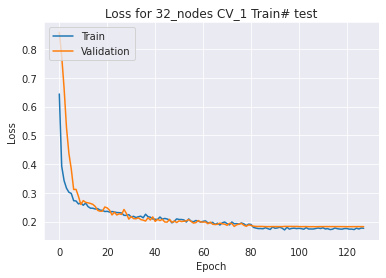

Test: resnet6_32_cv1 test
Recording time: 2020-03-27 22:04:01.255760
Duriation: 0:01:06.864038
-------------------------
cv_r2: 0.8244368005169861
cv_mse: 16.019811790532405
cv_rmse: 4.002475707675488
-------------------------
train_r2: 0.8425281816822439
train_mse: 13.736199208527722
train_rmse: 3.7062378780277614



Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping


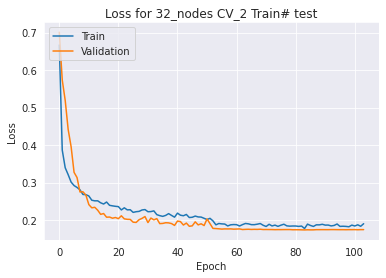

Test: resnet6_32_cv2 test
Recording time: 2020-03-27 22:05:07.583994
Duriation: 0:02:13.191988
-------------------------
cv_r2: 0.8248731276044801
cv_mse: 15.302089614135284
cv_rmse: 3.9117885441489912
-------------------------
train_r2: 0.835060444809469
train_mse: 14.547557825846472
train_rmse: 3.8141260894006206



Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping


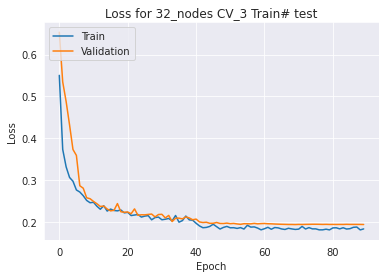

Test: resnet6_32_cv3 test
Recording time: 2020-03-27 22:06:07.788559
Duriation: 0:03:13.396517
-------------------------
cv_r2: 0.8076461335099536
cv_mse: 17.087420974499324
cv_rmse: 4.133693381771237
-------------------------
train_r2: 0.8355082101829007
train_mse: 14.448083673631832
train_rmse: 3.8010634924494267



Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping


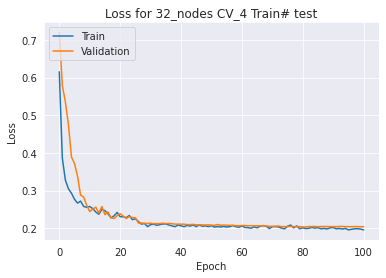

Test: resnet6_32_cv4 test
Recording time: 2020-03-27 22:07:12.497299
Duriation: 0:04:18.105565
-------------------------
cv_r2: 0.8034547769550376
cv_mse: 17.94104089859975
cv_rmse: 4.235686591167924
-------------------------
train_r2: 0.8177427728178036
train_mse: 15.892786475694294
train_rmse: 3.9865757832624094



Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00096: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping


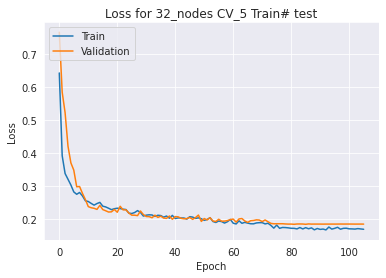

Test: resnet6_32_cv5 test
Recording time: 2020-03-27 22:08:16.360876
Duriation: 0:05:21.969022
-------------------------
cv_r2: 0.8016981470457399
cv_mse: 16.12872197432169
cv_rmse: 4.016058014312255
-------------------------
train_r2: 0.8518729900429012
train_mse: 13.288241187267525
train_rmse: 3.6453039910640546


Training # test
R2 (cross validation) mean: 0.8124217971264395 , STD: 0.011375489241497158
MSE (cross validation) mean: 16.495817050417692 , STD: 1.0277392870773088
RMSE (cross validation) mean: 4.059940447815179, STD: 0.12599906057176208



Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping


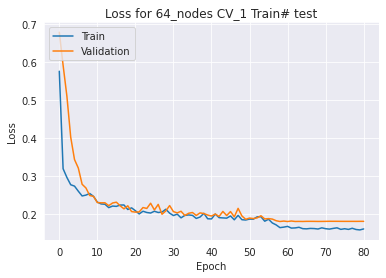

Test: resnet6_64_cv1 test
Recording time: 2020-03-27 22:09:17.672571
Duriation: 0:06:23.280860
-------------------------
cv_r2: 0.8259605870543607
cv_mse: 15.88076913461379
cv_rmse: 3.98506827226508
-------------------------
train_r2: 0.8506208985542976
train_mse: 13.030274984877542
train_rmse: 3.6097472189722013



Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping


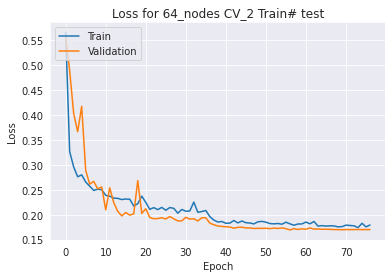

Test: resnet6_64_cv2 test
Recording time: 2020-03-27 22:10:18.614015
Duriation: 0:07:24.222187
-------------------------
cv_r2: 0.8291956917386439
cv_mse: 14.924396214835394
cv_rmse: 3.8632106096918135
-------------------------
train_r2: 0.8368338296956499
train_mse: 14.39114647170283
train_rmse: 3.793566458058015



Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping


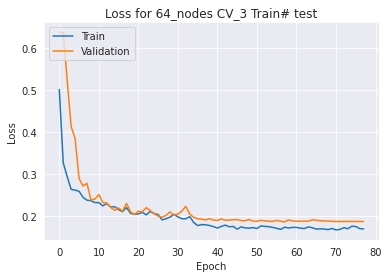

Test: resnet6_64_cv3 test
Recording time: 2020-03-27 22:11:23.365503
Duriation: 0:08:28.973815
-------------------------
cv_r2: 0.8153998818751088
cv_mse: 16.398630232397974
cv_rmse: 4.049522222731711
-------------------------
train_r2: 0.8458312491499504
train_mse: 13.541362852319494
train_rmse: 3.6798590804974443



Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00081: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping


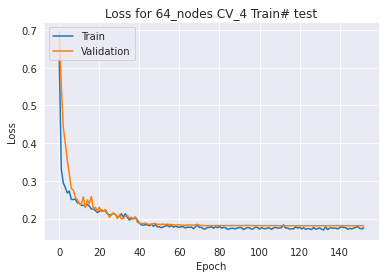

Test: resnet6_64_cv4 test
Recording time: 2020-03-27 22:12:48.559740
Duriation: 0:09:54.168125
-------------------------
cv_r2: 0.8256156852725169
cv_mse: 15.918148882633211
cv_rmse: 3.9897554915850684
-------------------------
train_r2: 0.8415446735445389
train_mse: 13.81726644384653
train_rmse: 3.717158382938038



Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping


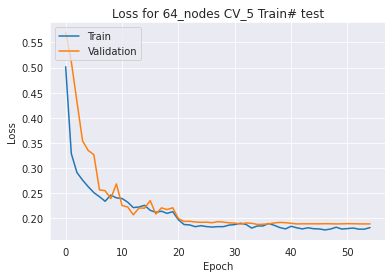

Test: resnet6_64_cv5 test
Recording time: 2020-03-27 22:13:46.282936
Duriation: 0:10:51.890970
-------------------------
cv_r2: 0.7965609093115973
cv_mse: 16.546555080243763
cv_rmse: 4.067745700046128
-------------------------
train_r2: 0.8392231165417455
train_mse: 14.423041451719397
train_rmse: 3.7977679565396563


Training # test
R2 (cross validation) mean: 0.8185465510504455 , STD: 0.013338054163576998
MSE (cross validation) mean: 15.933699908944828 , STD: 0.6351159569101678
RMSE (cross validation) mean: 3.9910604592639602, STD: 0.08012739422767869


R2 (cross validation): 1.630968348176885
RMSE (cross validation): 8.051000907079139


In [ ]:
text_file_name = "20200326_rn_newdata.txt"
retrain_times = ""

# Cross Validation
cross_validation = True

cv_score=[]
cv_score_total=0
epoch_n = 10000
verbose = 0
batch_size = 128

# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True

numOfTraining = 1

from datetime import datetime
start_time=datetime.now()

# If cv sets to True, applying cv training
if cross_validation:

  cv_score=[]
  cv_score_total=0
  epoch_n = 10000
  verbose = 0
  batch_size = 128

  Loss_function = 'mean_squared_error'
  optimizer = 'adam'
  activation = 'tanh'

  empty_list = ['test']
  optimizer_list = ['adadelta', 'adagrad', 'adam', 'ftrl', 'nadam', 'rmsprop', 'sgd']
  # optimizer_list = ['adam']

  activation_list = ['elu', 'hard_sigmoid', 'linear', 'relu', 'selu',
                     'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']

  loss_list = ['KLD', 'MAPE', 'MAE', 'MSLE', 'MSE', 'binary_crossentropy', 
               'hinge', 'squared_hinge']

  mse_sum = []
  rmse_sum = []
  r2_sum = []

  for i in empty_list:
    print('Activation: ' + i)

    for nodes in range(32, 65, 32):
      mse_result = []
      rmse_result = []
      r2_result = []
      cv_no = 0

      Kfold = KFold(n_splits=5, random_state=42, shuffle=True)
      Kfold_split = Kfold.split(np.arange(len(df_data)))

      for train_index, cv_index in Kfold_split:
        cv_no += 1

        # Set up GPU preferences
        config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.6
        sess = tf.Session(config=config) 
        K.set_session(sess)

        train_input=input_data[train_index]
        cv_input=input_data[cv_index]
        
        # 28 days output
        train_target=target_data[train_index]
        cv_target=target_data[cv_index]

        # 7 days output
        train_target_1=target_data_1[train_index]
        cv_target_1=target_data_1[cv_index]

        # Loop through each molecule type
        !mkdir -p ~/kaggle/UCLA
        model_name_rd = ('/root/kaggle/UCLA/concrete_model_%s.hdf5' %cv_no)
        model_name_wrt = ('/root/kaggle/UCLA/concrete_model_%s.hdf5' %cv_no)

        # Build the Neural Net
        new_model = build_model()
        nn_model=new_model.create_nn_model(train_input.shape[1], nodes, activation)

        # If retrain==False, then we load a previous saved model as a starting point.
        if not retrain:
            nn_model = load_model(model_name_rd)

        # compile
        #nn_model.compile(loss=loss_function, optimizer=Adam())#, metrics='rmse')
        nn_model.compile(optimizer = optimizer, loss = Loss_function, metrics =["accuracy"])

        # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
        es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00000001, patience=20,verbose=1, mode='auto', restore_best_weights=True)
        # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
        rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-6, mode='auto', verbose=1)
        # Save the best value of the model for future use
        sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

       
        # single outputs
        history = nn_model.fit(train_input,train_target, 
                validation_data=(cv_input,cv_target), 
                callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

        # two outputs
        # history = nn_model.fit(train_input,[train_target,train_target_1], 
        #         validation_data=(cv_input,[cv_target,cv_target_1]), 
        #         callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

        cv_predict=nn_model.predict(cv_input)
        train_predict=nn_model.predict(train_input)

        cv_predict_reverse=target_scaler.inverse_transform(cv_predict) *0.00689476
        train_predict_reverse=target_scaler.inverse_transform(train_predict) *0.00689476
        cv_target_reverse=target_scaler.inverse_transform(cv_target) *0.00689476
        train_target_reverse=target_scaler.inverse_transform(train_target) *0.00689476
        cv_target_1_reverse=target_scaler.inverse_transform(cv_target_1) *0.00689476
        train_target_1_reverse=target_scaler.inverse_transform(train_target_1) *0.00689476

        plot_history(history,"%s_nodes CV_%s Train# %s" %(nodes, cv_no, i))

        end_time=datetime.now()
        processing_time = end_time - start_time

        # validation
        r2_v = r2_score(cv_target_reverse, cv_predict_reverse)
        mse_v = mean_squared_error(cv_target_reverse, cv_predict_reverse)
        rmse_v = math.sqrt(mse_v)
        # Training
        r2_t = r2_score(train_target_reverse, train_predict_reverse)
        mse_t = mean_squared_error(train_target_reverse, train_predict_reverse)
        rmse_t = math.sqrt(mse_t)

        # text report
        test_name = model_name + num_of_layers + "_" + str(nodes) + "_cv" + str(cv_no)
        record =["Test: {}".format(test_name+' '+i),
                "Recording time: {}".format(datetime.now()),
                "Duriation: {}".format(processing_time),
                "-------------------------",
                "cv_r2: {}".format(r2_v),
                "cv_mse: {}".format(mse_v),
                "cv_rmse: {}".format(rmse_v),
                "-------------------------",
                "train_r2: {}".format(r2_t),
                "train_mse: {}".format(mse_t),
                "train_rmse: {}".format(rmse_t),
                ]
        
        # Upload to Google Drive
        with open(r"/content/gdrive/My Drive/UCLA/_Lab/results/"+text_file_name, "a+") as file:
          for line in record:
            file.write(line + "\n")
            print(line)
          file.write("\n")
        print('\n')
        r2_result.append(r2_v)
        mse_result.append(mse_v)
        rmse_result.append(rmse_v)
        r2_sum.append(r2_v)
        mse_sum.append(mse_v)
        rmse_sum.append(rmse_v)

        sess.close()

  
      Summary = ["Training # {}".format(i),
                 "R2 (cross validation) mean: {} , STD: {}".format(sum(r2_result)/cv_no, std(r2_result)),
                 "MSE (cross validation) mean: {} , STD: {}".format(sum(mse_result)/cv_no, std(mse_result)),
                 "RMSE (cross validation) mean: {}, STD: {}".format(sum(rmse_result)/cv_no, std(rmse_result)),
                 ]
      with open(r"/content/gdrive/My Drive/UCLA/_Lab/results/"+text_file_name, "a+") as file:
        for line in Summary:
          file.write(line + "\n")
          print(line)
        file.write("\n")
      print('\n')
    
    retrain = True

    print("R2 (cross validation): {}".format(sum(r2_sum)/cv_no/numOfTraining))
    print("RMSE (cross validation): {}".format(sum(rmse_sum)/cv_no/numOfTraining))

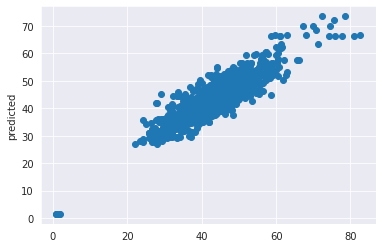

In [ ]:
Output = True
if Output:
  plt.plot(cv_target_reverse, cv_predict_reverse, marker='o', linestyle='None')
  plt.ylabel('predicted')
  plt.show